## What is XML?

> XML stands for Extensible Markup Language.

> XML was designed to store and transport data.

> XML was designed to be both human and machine-readable

> [source](http://www.w3schools.com/xml/)
<!-- TEASER_END -->

## XML structure

XML documents are a collection of elements. They have a tree-like structure. What that means is that there is a root node that has separate 'leaves'. Each element can also have attributes that describe that element.

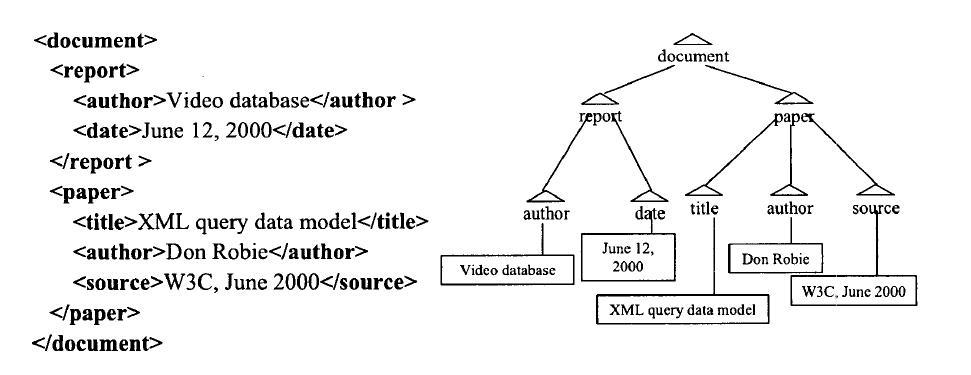

In [1]:
import os.path
from IPython.display import Image
filename = os.path.join('..', 'files', 'base.jpg')
Image(filename=filename) # source: https://wiki.csc.calpoly.edu/csc560/wiki/Relative%20Region%20Coordinate

## [RSS](https://en.wikipedia.org/wiki/RSS)

---
RSS is often referred to as Really Simple Syndication. You can use software (often referred to as an RSS reader) that allows you to subscribe to a website's RSS feed which will notify you any time new content is published to that feed. 

---
The feed is really just an XML document which the RSS reader knows how to parse properly. Often, the XML document is automatically created each time the webmaster publishes their content. 

---
This website works the same way. Each time I write a new article, the framework I use, Nikola, automatically re-generates the XML document that describes all the articles on the website so that anyone who subscribes to the feed will know that a new article has been published :)

---
We're going to use Python to parse through the XML document that describes the content published on this very website.

## Python's ElementTree

Python's standard library has an xml module aptly named... xml. It includes an API (application programming interface) to create and parse xml documents through the xml.etree.ElementTree object.

From the Python documentation of ElementTree: 
> The Element type is a flexible container object, designed to store hierarchical data structures in memory. The type can be described as a cross between a list and a dictionary.

> Each element has a number of properties associated with it:

> - a tag which is a string identifying what kind of data this element represents (the element type, in other words).
> - a number of attributes, stored in a Python dictionary.
> - a text string.
> - an optional tail string.
> - a number of child elements, stored in a Python sequence

> To create an element instance, use the Element or SubElement factory functions.
The ElementTree class can be used to wrap an element structure, and convert it from and to XML.

So we know a little bit about elements:
* Each element is a node in a tree.
* An element has an opening tag and a closing tag. 
* The element's tag describes the name of the element itself. 
* Each element has one parent. An element can have multiple children.
* An element can have attributes that describe that element.
* An element may have text associated with it which will lie between the opening tag and the closing tag

### For example:
    
    <html>
        <head>
            <title>Example page</title>
        </head>
        <body>
            <p>Moved to <a href="http://example.org/">example.org</a>
            or <a href="http://example.com/">example.com</a>.</p>
        </body>
    </html>

Our root element is html. It has two child elements; head and body. Our 'a' elements both have href attributes. They also both have text associated with them, which are the strings located between their opening and closing tags (example.org and example.com, respectively).

---
This HTML snippet is valid XML. It's important to note that although html and xml are very similar, they are not the same. HTML follows much of the same conventions as XML, but its purpose is to encode information in a way that can be read by humans and displayed on a client (in most cases a web-browser). For this reason, it has a couple of differences that make some HTML documents diverge from the XML standard. XML documents are meant to encapsulate data which will be read by software, but can also be read and understood by a human.

## First things first
We're going to need to install the lxml module. This is the easy part.

    pip install lxml
    
voila!

In [2]:
from lxml import etree
from pprint import pprint
from collections import namedtuple

## The lxml etree object

lxml is a library that allows us greater power and flexibility than Python's standard xml module. If you're not familiar with the terms library and module, a module basically refers to a Python script (a file ending in .py) and a library just refers to code someone has written that's meant to be re-used by other people.

But I digress, lxml has an ElementTree that is similar to the ElementTree found in the standard library.

One of the main differences between the ElementTree found in the standard library's xml module and the one in lxml, is that lxml Elements have a concept of who their ancestors, descendants, and siblings are.

### Let's starts by creating some example xml

In [3]:
root = etree.Element("root")
a = etree.SubElement(root, "a")
b = etree.SubElement(root, "b")
c = etree.SubElement(root, "c")
d = etree.SubElement(root, "d")
e = etree.SubElement(d,    "e" , spunky='So spunky')

Now we have a series of elements. We can create an ElementTree by using the getroottree() method of lxml Element objects.

In [4]:
tree = d.getroottree()
print('Our generated xml:', etree.tostring(tree))
print()

# We can get the root Element of an ElementTree with the getroot() method
root = tree.getroot()

# Elements are iterable. 
# By default, you will only get the immediate children of that element
print('Children of root:', [child.tag for child in root])

# To traverse the entire tree, you can use the element.iter() method
print('All elements in the tree:', [element.tag for element in tree.iter()])

# We can iterate over siblings
print("a's siblings:", [element.tag for element in a.itersiblings()])

# We can also iterate over the ancestors
print('Ancestors of e:', [ancestor.tag for ancestor in e.iterancestors()])

# We can also iterate over descendants of elements
print('Descendants of root:', 
      [descendant.tag for descendant in root.iterdescendants()])

# Each element has an .attrib property which is a dictionary of its attributes
# Elements also support the .get() method to retrieve attributes
print(e.attrib)
print(e.get('spunky'))

Our generated xml: b'<root><a/><b/><c/><d><e spunky="So spunky"/></d></root>'

Children of root: ['a', 'b', 'c', 'd']
All elements in the tree: ['root', 'a', 'b', 'c', 'd', 'e']
a's siblings: ['b', 'c', 'd']
Ancestors of e: ['d', 'root']
Descendants of root: ['a', 'b', 'c', 'd', 'e']
{'spunky': 'So spunky'}
So spunky


### Let's try parsing the RSS feed for this website!
#### Remember, RSS feeds are just XML documents

In [5]:
# The parse() method of lxml.etree supports url's! cool!
tree = etree.parse('http://knowsuchagency.github.io/pyhi/rss.xml')

# We can use namedtuples to help make it more clear what we want to parse
Element = namedtuple('Element', ['tag', 'text', 'parent'])


elements = []

for el in tree.iter():
    tag = el.tag
    
    # The text of some of these elements is really messy, 
    # so I use this line to replace them
    text = el.text if el.text and not el.text.startswith('<div') else 'Snip'
    
    # The root node won't have a parent, 
    # so we use this line to deal with that situation
    parent = el.getparent().tag if el.getparent() is not None else 'None'
    
    element = Element(el.tag, text, parent)
    elements.append(element)
    
elements[:10]

[Element(tag='rss', text='Snip', parent='None'),
 Element(tag='channel', text='Snip', parent='rss'),
 Element(tag='title', text='PyHawaii', parent='channel'),
 Element(tag='link', text='http://knowsuchagency.github.io/pyhi/', parent='channel'),
 Element(tag='description', text='For technical talks and all things PyHawaii :)', parent='channel'),
 Element(tag='{http://www.w3.org/2005/Atom}link', text='Snip', parent='channel'),
 Element(tag='language', text='en', parent='channel'),
 Element(tag='lastBuildDate', text='Tue, 08 Sep 2015 08:00:55 GMT', parent='channel'),
 Element(tag='generator', text='https://getnikola.com/', parent='channel'),
 Element(tag='docs', text='http://blogs.law.harvard.edu/tech/rss', parent='channel')]

### [XPath](https://en.wikipedia.org/wiki/XPath)

XPath is a W3C standard syntax for traversing XML documents and extracting information from them.
Elements and ElementTree objects can be traversed using XPath syntax.

In XPath, '/' is the root node. '//' then refers to arbitrary depth within the tree.
XPath also allows for functions, so for example, element/text() will return the text for that element if there is any.

In [8]:
for element in tree.xpath('//item'):
    print(element.xpath('./title/text()'), 
          element.xpath('./link/text()'),
         sep='\n')
    print()

['Counter and namedtuple']
['http://knowsuchagency.github.io/pyhi/posts/counter-and-namedtuple/']

['FUNctional Python']
['http://knowsuchagency.github.io/pyhi/posts/functional-python/']

['Tablib, Flask, and Openshift']
['http://knowsuchagency.github.io/pyhi/posts/tablib-flask-and-openshift/']

['pathlib and os.path']
['http://knowsuchagency.github.io/pyhi/posts/pathlib-and-ospath/']

['Getting Started']
['http://knowsuchagency.github.io/pyhi/posts/getting-started/']



#### We can also get all the elements of a certain name simply by passing that tag as a string in the ElementTree.iter() method

In [9]:
for element in tree.iter('item'):
    print(element.xpath('./title/text()'), 
          element.xpath('./link/text()'),
         sep='\n')
    print()

['Counter and namedtuple']
['http://knowsuchagency.github.io/pyhi/posts/counter-and-namedtuple/']

['FUNctional Python']
['http://knowsuchagency.github.io/pyhi/posts/functional-python/']

['Tablib, Flask, and Openshift']
['http://knowsuchagency.github.io/pyhi/posts/tablib-flask-and-openshift/']

['pathlib and os.path']
['http://knowsuchagency.github.io/pyhi/posts/pathlib-and-ospath/']

['Getting Started']
['http://knowsuchagency.github.io/pyhi/posts/getting-started/']

